# Active Learner
Using Parameters from Park, Lee & Moon  
Pool based, SVM, inductive -> those parameters are standard  
Initial set: Normally, k-means is used. PLM recommend their own algorithm, LCA.  
After all documents are labeled, the corpus becomes input to the Sentiment Lexicon Extraction Model (SLE-BE), which creates the domain-specific lexicon.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_pickle("./data/cleaned_submissions.pkl")

In [3]:
text = data["text"]
labels = data["sentiment"]

# Get labeled instances
indices = []
for i in range(0, len(labels), 10):
    indices.append(i)
    
# Set seed
X_seed = text[indices]
y_seed = labels[indices]

In [4]:
# Get unlabeled instances
new_indices = []
for i in range(0, len(data["text"].index)):
    if i not in indices:
        new_indices.append(i)

In [5]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
y_train = lenc.fit_transform(y_seed)

# Vectorize text using tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=' '.join, lowercase=False, min_df=5) # min_df = Minimum occurance of words
X_train = tfidf.fit_transform(data["text"])

In [ ]:
# Label Encoding
# Bullish: 1
# Neutral: 2
# Bearish: 0

In [6]:
# Set aside test set, to better judge the performance of the AL. This is not done in the literature
from sklearn.model_selection import train_test_split

X_train_seed, X_test, y_train_seed, y_test = train_test_split(X_train[indices], y_train, test_size=0.2, random_state=10)

In [7]:
# y_train_seed = y_train # To feed the Active Leaner
# X_train_seed = X_train[indices] # To feed the Active Learner
X_train_pool = X_train[new_indices] # Instances that need to be labeled

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


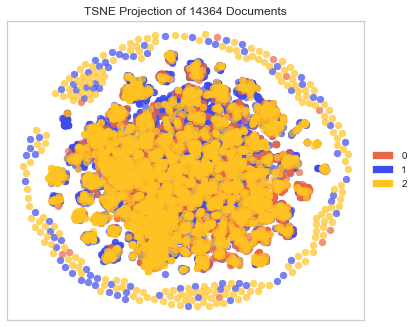

<AxesSubplot:title={'center':'TSNE Projection of 14364 Documents'}>

In [10]:
# Try to visualize seed via t-sne
# Playing with t-sne
# https://www.scikit-yb.org/en/latest/api/text/tsne.html
# https://www.districtdatalabs.com/text-analytics-with-yellowbrick

from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(decompose_by = 100, alpha = 0.7, colors = ["#E96744", "#3F4CEC", "#FFC322"], labels = ["bearish", "bullish", "neutral"], random_state = 2)
tsne.fit_transform(X_train_seed, y_train_seed)
tsne.show(labels = ["bearish", "bullish", "neutral"])

In [11]:
print((X_train_seed[y_train_seed != 2].shape))
print((y_train_seed[y_train_seed != 2].shape))

(10242, 19267)
(10242,)


/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


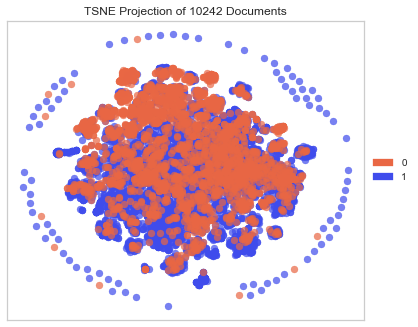

<AxesSubplot:title={'center':'TSNE Projection of 10242 Documents'}>

In [12]:
# Excluding neutral
X_train_seed[y_train_seed != 2]
y_train_seed[y_train_seed != 2]

# Try to visualize seed via t-sne
# Playing with t-sne
# https://www.scikit-yb.org/en/latest/api/text/tsne.html
# https://www.districtdatalabs.com/text-analytics-with-yellowbrick

from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(decompose_by = 100, alpha = 0.7, colors = ["#E96744", "#3F4CEC"], labels = ["bearish", "bullish"], random_state = 2)
tsne.fit_transform(X_train_seed[y_train_seed != 2], y_train_seed[y_train_seed != 2])
tsne.show(labels = ["bearish", "bullish"])

In [8]:
# Run this first
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.svm import SVC

learner = ActiveLearner(
    estimator = SVC(probability=True),
    query_strategy = uncertainty_sampling,
    X_training = X_train_seed,
    y_training = y_train_seed
)

In [32]:
est = pickle.load(open('AL/al_init.sav', 'rb'))

In [16]:
# Using Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# for sentence in data["text"][indices][:30]:
#     vs = analyzer.polarity_scores(" ".join(sentence))
#     print("{:} {}".format(" ".join(sentence), str(vs)))
#     print("-"*40)


def vader_sentiment_labels(query_text):
    sentiment_list = []
    for item in query_text:
        sentence = tfidf.inverse_transform(item)
        vs = analyzer.polarity_scores(" ".join(sentence[0]))
        if vs["compound"] > 0.05:
            sentiment_list.append(np.int(2)) # Positive Sentiment
        elif vs["compound"] < -0.05:
            sentiment_list.append(np.int(0)) # Negative Sentiment
        else:
            sentiment_list.append(np.int(1)) # Neutral Sentiment
    return sentiment_list

In [17]:
'''
Try to fix the following error by introducing some noise:
ValueError: The number of classes has to be greater than one; got 1 class
'''
def catch_value_error_for_svm(l):
    zeros, ones, twos = 0, 0, 0
    
    for item in l:
        if item == 0:
            zeros = zeros + 1
        elif item == 1:
            ones = ones + 1
        else:
            twos = twos + 1

    if zeros == len(l):
        l[0] = 1
    elif ones == len(l):
        l[0] = 2
    else:
        l[0] = 1

    return l

In [18]:
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [30]:
accuracy_scores = [est.score(X_test, y_test)] # Get scores of initial AL with seed data

In [34]:
learner = ActiveLearner(
    estimator = est,
    query_strategy = uncertainty_sampling
)

In [20]:
# DEV
accuracy_scores = [learner.score(X_test, y_test)]

# the active learning loop
n_queries = 20
for i in range(n_queries):
    print('Query no. %d' % (i + 1))
    query_idx, query_sample = learner.query(X_train_pool, n_instances=100)
    learner.teach(
        X=X_train_pool[query_idx], y=np.array(catch_value_error_for_svm(vader_sentiment_labels(query_sample))), only_new = False #True
    )
    # remove queried instance from pool
    X_train_pool = delete_rows_csr(X_train_pool, query_idx) # np.delete(X_train_pool, query_idx, axis = 0) -> For normal numpy arrays
    accuracy_scores.append(learner.score(X_test, y_test))

Query no. 1
Query no. 2
Query no. 3
Query no. 4
Query no. 5
Query no. 6
Query no. 7
Query no. 8
Query no. 9
Query no. 10
Query no. 11
Query no. 12
Query no. 13
Query no. 14
Query no. 15
Query no. 16
Query no. 17
Query no. 18
Query no. 19
Query no. 20


In [21]:
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
# The accuracy drops after every iteration, I assume that is because I use VADER... Will be better when I act as the oracle
np.savetxt("./data/evaluation/AL_accuracy_scores.csv", accuracy_scores, delimiter = ",", fmt ='% s')

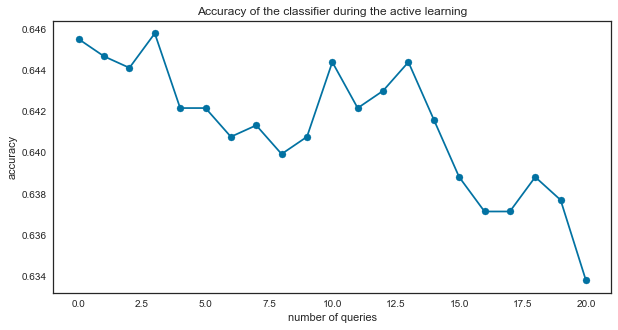

In [22]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

In [ ]:
# Final implementation

In [1]:
import InitActiveLearner as ial
import scipy
import pickle
import numpy as np

Active Learner Object already exists, loading object now.
Initial model already exists, try load_initial_model
Files already exist, use load_initial_seed instead!
Files already exist, use load_test_data instead!
Files already exist, use load_pool_data instead!
File already exists, try load_new_indices instead


In [2]:
accuracy_scores = ial.load_accuracy_scores()
est = ial.load_initial_model() # Load initial estimator
new_indices = ial.load_new_indices()
X_train_seed, y_train_seed = ial.load_initial_seed()
X_test, y_test = ial.load_test_data()
X_train_pool = ial.load_pool_data()

In [4]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.svm import SVC
import pickle

learner = ActiveLearner(
    estimator = est,
    query_strategy = uncertainty_sampling
)

In [5]:
accuracy_scores = pickle.load(open("AL/data/acc_scores/accuracy_scores.pkl", "rb"))

In [6]:
accuracy_scores.append(learner.score(X_test, y_test))

In [8]:
# Need to add to index before running!
pickle.dump(accuracy_scores, open("AL/data/acc_scores/accuracy_scores_0.pkl", "wb"))

In [111]:
#######################################
''' Start every iteration from here '''
#######################################
import os
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)
newest_pool_file = newest("C:\DEV\Master Thesis\App\AL\data\X_train_pool_iterations")
s = re.split('(?<=X_train_pool_iterations)(.*)', newest_pool_file)
s = s[1][1:]

X_train_pool = scipy.sparse.load_npz("AL/data/X_train_pool_iterations/" + s)

In [9]:
query_idx, query_sample = learner.query(X_train_pool, n_instances = 10)

In [12]:
unlabeled_data = data.loc[new_indices, ["text", "sentiment"]]
unlabeled_data = unlabeled_data.reset_index()

In [23]:
len(new_indices)

161589

In [24]:
len(query_idx)

10

In [22]:
len(set(query_idx) ^ set(new_indices))

161581

In [10]:
with open('AL/data/readme.txt', 'w') as f:
    f.write('readme')

In [115]:
# Data so far is from cleaned submissions
# Get the uncleaned ones now!!
from Dataframe_Cleaner import Cleaner

s = pd.read_pickle("./data/submissions.pkl")
l = list(unlabeled_data.loc[query_idx, "index"])
s = s.loc[l, ["title", "selftext"]]
s = s.reset_index()
cl = Cleaner(s)
s = cl.missing_content_flag()

In [116]:
s.columns.values[0] = "old_index"

In [161]:
tfidf.inverse_transform(query_sample[1])

[array(['anyone', 'buy', 'else', 'gme', 'problem', 'schwab', 'seem'],
       dtype='<U163')]

In [160]:
from datetime import datetime
import xlsxwriter # cannot modify excel files
from openpyxl import load_workbook # can modify excel files
import re

today = datetime.today()
creation_time = today.strftime("%d%b%Y_%H") + "H" + today.strftime("_%M") + "M"

workbook = xlsxwriter.Workbook('AL/data/annotations/' + creation_time + '.xlsx')
worksheet = workbook.add_worksheet()

for i in range(0, len(s["title"])):
    # row, column, item
    worksheet.write(i, 0, i)
    worksheet.write(i, 1, s.loc[[i], ["title"]].values[0][0])
    if s["missing_content"][i] == True:
        worksheet.write(int(i/10), 2, " ")
    else:
        worksheet.write(int(i/10), 2, str(re.sub(r'\n',' ', s["selftext"][i][:100])))
    worksheet.write(i, 3, "?")

workbook.close()

wb = load_workbook(filename = "AL/data/annotations/" + creation_time + ".xlsx")
ws = wb.active

ws["E2"] = "Number of annotations:"
ws["E3"] = 0

wb.save(filename = "AL/data/annotations/" + creation_time + ".xlsx")
wb.close()

In [23]:
def load_annotation():
    wb = load_workbook(filename =  "AL/data/annotations/" + creation_time + ".xlsx")
    ws = wb.active
    return ws, wb

ws, wb = load_annotation()

def get_annotation_count():
    i = ws["E3"].value
    return i

def increment_annotation_count():
    i = get_annotation_count()
    i = i + 1
    ws["E3"] = i

def save_to_excel():
    wb.save(filename =  "AL/data/annotations/" + creation_time + ".xlsx")

def count_annotations():
    x = get_annotation_count()
    m = len(ws['A'])

    return str(x) + " / " + str(m)

In [24]:
import tkinter as tk
from tkinter import Tk, Button, Frame, Text, messagebox

def bullish_func_button():
    increment_annotation_count()
    row = get_annotation_count()
    cell = "D" + str(row)
    ws[cell] = "bullish"

def bearish_func_button():
    increment_annotation_count()
    row = get_annotation_count()
    cell = "D" + str(row)
    ws[cell] = "bearish"

def neutral_func_button():
    increment_annotation_count()
    row = get_annotation_count()
    cell = "D" + str(row)
    ws[cell] = "neutral"

def bullish_func(self):
    bullish_func_button()
    gui.title(count_annotations())
    update_label()
    update_content()

def bearish_func(self):
    bearish_func_button()
    gui.title(count_annotations())
    update_label()
    update_content()

def neutral_func(self):
    neutral_func_button()
    gui.title(count_annotations())
    update_label()
    update_content()

def on_saving():
    save_to_excel()
    return ""

def update_label():
    row = get_annotation_count() + 1
    cell = "B" + str(row)
    label.config(text=ws[cell].value)

def update_content():
    row = get_annotation_count() + 1
    cell = "C" + str(row)
    content.config(text=ws[cell].value)

gui = tk.Tk()

BUTTON_HEIGHT = 3
BUTTON_WIDTH = 10

gui.config(bg = "#222222")
gui.geometry("500x500")
gui.title(count_annotations())

# Bullish button
bullish = Button(gui, text = "bullish <a>", command = bullish_func_button)
gui.bind('a', bullish_func)
bullish.config(height = BUTTON_HEIGHT, width = BUTTON_WIDTH)
bullish.place(x=5,y=440)

# Bearish button
bearish = Button(gui, text = "bearish <b>", command = bearish_func_button)
bearish.config(height = BUTTON_HEIGHT, width = BUTTON_WIDTH)
gui.bind('b', bearish_func)
bearish.place(x=415,y=440)

# Neutral button
neutral = Button(gui, text = "Neutral < >", command = neutral_func_button)
neutral.config(height = BUTTON_HEIGHT, width = BUTTON_WIDTH)
gui.bind('<space>', neutral_func)
neutral.place(x=205,y=440)

# Title    
row = get_annotation_count() + 1
cell = "B" + str(row)
label = tk.Label(gui, justify = tk.CENTER, pady = 10, wraplengt=400, font = ("Arial", 15), text = ws[cell].value)
label.pack(pady = 50)

# Content
row = get_annotation_count() + 1
cell = "C" + str(row)
content = tk.Label(gui, justify = tk.CENTER, pady = 2, wraplengt=400, font = ("Arial", 15), text = ws[cell].value)
content.pack(pady = 50)
print(cell)

# Menu
menubar = tk.Menu(gui)
filemenu = tk.Menu(menubar, tearoff=0)
filemenu.add_command(label="Save", command=on_saving)
menubar.add_cascade(label="File", menu=filemenu)
gui.config(menu=menubar)

gui.mainloop()

C1


In [25]:
wb = load_workbook(filename = "AL/data/annotations/" + creation_time + ".xlsx")
ws = wb.active

In [27]:
# Label Encoding
# Bullish: 1
# Neutral: 2
# Bearish: 0
sentiment_list = []
for i in range(len(ws["D"])):
    cell = "D" + str(i+1)
    if ws[cell].value == "bullish":
        sentiment_list.append(1)
    elif ws[cell].value == "neutral":
        sentiment_list.append(2)
    else:
        sentiment_list.append(0)
wb.close()

In [40]:
'''
Try to fix the following error by introducing some noise:
ValueError: The number of classes has to be greater than one; got 1 class
'''
def catch_value_error_for_svm(l):
    zeros, ones, twos = 0, 0, 0
    
    for item in l:
        if item == 0:
            zeros = zeros + 1
        elif item == 1:
            ones = ones + 1
        else:
            twos = twos + 1

    if zeros == len(l):
        l[0] = 1
    elif ones == len(l):
        l[0] = 2
    elif twos == len(l):
        l[0] = 1

    return l

In [45]:
learner.teach(
    X = X_train_pool[query_idx], 
    y = np.array(catch_value_error_for_svm(sentiment_list)), 
    only_new = False #True
)

In [49]:
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [50]:
X_train_pool = delete_rows_csr(X_train_pool, query_idx)

In [52]:
scipy.sparse.save_npz("AL/data/X_train_pool_iterations/X_train_pool" + creation_time + ".npz", X_train_pool)

In [53]:
import os
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)
newest_pool_file = newest("C:\DEV\Master Thesis\App\AL\data\X_train_pool_iterations")
s = re.split('(?<=X_train_pool_iterations)(.*)', newest_pool_file)
s = s[1][1:]

In [110]:
s

'X_train_pool06Dec2021_20H_02M.npz'

In [97]:
X_train_pool = scipy.sparse.load_npz("AL/data/X_train_pool_iterations/" + s)

In [102]:
accuracy_scores.append(learner.score(X_test, y_test))

In [106]:
# Iterate the counter after every iteration!
pickle.dump(accuracy_scores, open("AL/data/acc_scores/accuracy_scores_1.pkl", "wb"))
filename = 'AL/al_1.sav'
pickle.dump(learner.estimator, open(filename, 'wb'))

In [ ]:
# Final implementation end

In [50]:
# query_idx, query_sample = learner.query(X_train_pool, n_instances = 5) # Need to update vader sentiment to work with list.

In [57]:
# new_label = vader_sentiment_labels(query_sample)

In [60]:
# learner.teach(X = X_train_pool[query_idx], y = np.array(vader_sentiment_labels(query_sample)))

In [23]:
# Get labels for unlabeled instances

predictions = learner.predict(X_train)

In [24]:
import scipy.sparse
scipy.sparse.save_npz('./data/X_sparse.npz', X_train)
np.save('./data/y_sparse.npy', predictions)

In [39]:
print("X:", X_train.shape[0], "- y:", len(predictions))

X: 179544 - y: 179544
